# Basic CBB Ranking System

Basic Bayesian ranking System

In [154]:
import pandas as pd 
import numpy as np
import seaborn as sns
import pystan
import arviz
import matplotlib.pyplot as plt

from pyprojroot import here

In [168]:
games = pd.read_csv(here("data/acc_2018_games.csv"), header=None)
games.columns = ['game_id', 'date', 'team_i', 'home_i', 'score_i', 'team_j', 'home_j', 'score_j']
games['date'] = pd.to_datetime(games['date'], format="%Y%m%d")
teams = pd.read_csv(here("data/acc_2018_teams.csv"), header=None)
teams.columns = ['team_id', 'team_name']
teams = teams.set_index('team_id')
games.head()

,game_id,date,team_i,home_i,score_i,team_j,home_j,score_j
0,737037,2017-12-09,1,1,89,3,-1,84
1,737058,2017-12-30,2,1,78,8,-1,62
2,737058,2017-12-30,3,1,100,4,-1,93
3,737058,2017-12-30,9,1,73,15,-1,69
4,737058,2017-12-30,10,1,68,5,-1,59


In [145]:
games.head()

,game_id,date,team_i,home_i,score_i,team_j,home_j,score_j
0,737037,2017-12-09,1,1,89,3,-1,84
1,737058,2017-12-30,2,1,78,8,-1,62
2,737058,2017-12-30,3,1,100,4,-1,93
3,737058,2017-12-30,9,1,73,15,-1,69
4,737058,2017-12-30,10,1,68,5,-1,59


<AxesSubplot:xlabel='score_i'>

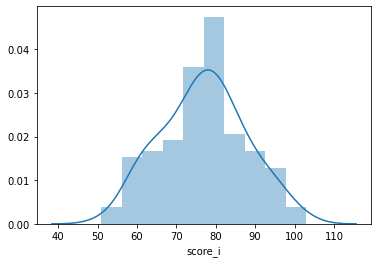

In [146]:
sns.distplot(games['score_i'])

How should this problem be set up? There is a parameter for team strength, theta, that matches the number of teams. This parameter has a mean of zero and a standard deviation tau. Then for each game, we take theta_i - theta_j, add home court, and draw from a normal distribution.

In [176]:
cutoff = pd.to_datetime("2018-03-01")
train = games[games['date'] < cutoff]
test = games[games['date'] >= cutoff]

In [177]:
games.dtypes

game_id             int64
date       datetime64[ns]
team_i              int64
home_i              int64
score_i             int64
team_j              int64
home_j              int64
score_j             int64
dtype: object

In [193]:


model_code = """
data {
    int<lower=0> k;
    int<lower=0> n;
    int h[n];
    int team_i[n];
    int team_j[n];
    vector[n] diff;
    
    int<lower=0> n_test;
    int h_test[n_test];
    int team_i_test[n_test];
    int team_j_test[n_test];
}
transformed data {}
parameters {
    vector[k] theta_raw;
    real<lower=0> eta;
    real<lower=0> sigma;
    real<lower=0> tau_theta;
}
transformed parameters {
    vector[k] theta;
    theta = theta_raw * tau_theta;
}
model {
    vector[n] mu;
    eta ~ normal(4, 1);
    sigma ~ cauchy(0, 1)T[0,];
    tau_theta ~ cauchy(0, 1)T[0,];
    theta_raw ~ normal(0, 1);

    for (i in 1:n) {
        mu[i] = theta[team_i[i]] - theta[team_j[i]] + eta * h[i];
        //diff[i] ~ normal(theta[team_i[n]] - theta[team_j[n]] + eta * h[n], sigma);
    }
    
    diff ~ normal(mu, sigma);
}
generated quantities {
    vector[n_test] mu_test;
    vector[n_test] diff_test;

    for (i in 1:n_test) {
        mu_test[i] = theta[team_i_test[i]] - theta[team_j_test[i]] + eta * h_test[i];
        diff_test[i] = normal_rng(mu_test[i], sigma);
    }
}
"""
dat = {
    'k': len(np.union1d(train['team_i'].unique(), train['team_j'].unique())),
    'n': len(train),
    'h': train['home_i'],
    'team_i': train['team_i'],
    'team_j': train['team_j'],
    'diff': train['score_i'] - train['score_j'],
    'n_test': len(test),
    'h_test': test['home_i'],
    'team_i_test': test['team_i'],
    'team_j_test': test['team_j']
}

sm = pystan.StanModel(model_code=model_code)
print('fitting model')
fit = sm.sampling(data=dat, warmup=500, iter=2500, chains=2, refresh=100)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2132d90a8339061e72fb678045ad017b NOW.
fitting model


In [194]:
# arviz.plot_trace(fit, var_names=["theta", "eta", "tau_theta", "sigma"])
print(fit)

Inference for Stan model: anon_model_2132d90a8339061e72fb678045ad017b.
2 chains, each with iter=2500; warmup=500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta_raw[1]   -0.39  8.5e-3   0.42  -1.25  -0.67  -0.38  -0.11   0.43   2514    1.0
theta_raw[2]    0.38  8.6e-3   0.42  -0.42   0.09   0.36   0.64   1.25   2405    1.0
theta_raw[3]     1.4    0.01   0.48   0.54   1.06   1.38   1.71   2.41   1972    1.0
theta_raw[4]   -0.09  8.8e-3   0.41   -0.9  -0.36  -0.09   0.17   0.73   2143    1.0
theta_raw[5]   -0.78  9.3e-3   0.44  -1.68  -1.07  -0.76  -0.48   0.05   2214    1.0
theta_raw[6]    0.39  8.6e-3   0.43  -0.43    0.1   0.38   0.66   1.25   2480    1.0
theta_raw[7]   -0.05  8.4e-3   0.41  -0.85  -0.32  -0.06   0.23   0.74   2379    1.0
theta_raw[8]    0.12  8.7e-3   0.43  -0.72  -0.16   0.11    0.4   0.98   2441    1.0
theta_raw[9]     0.8  9.3e-3   0.44  -0.04    0

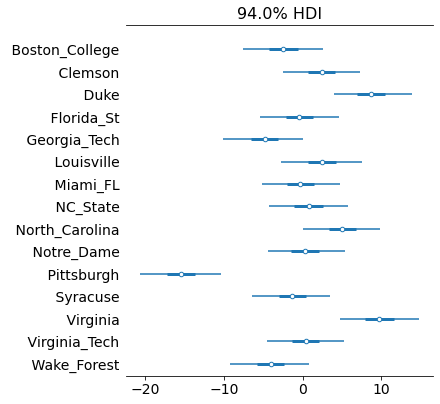

In [180]:
# fig, ax = plt.subplots(figsize=(6, 10))
axes=arviz.plot_forest(fit, var_names=['theta'], combined=True)
team_names = teams.loc[np.flip(np.arange(1, len(teams) + 1)), 'team_name'].tolist()
axes[0].set_yticklabels(team_names)
plt.show()

## Make Predictions

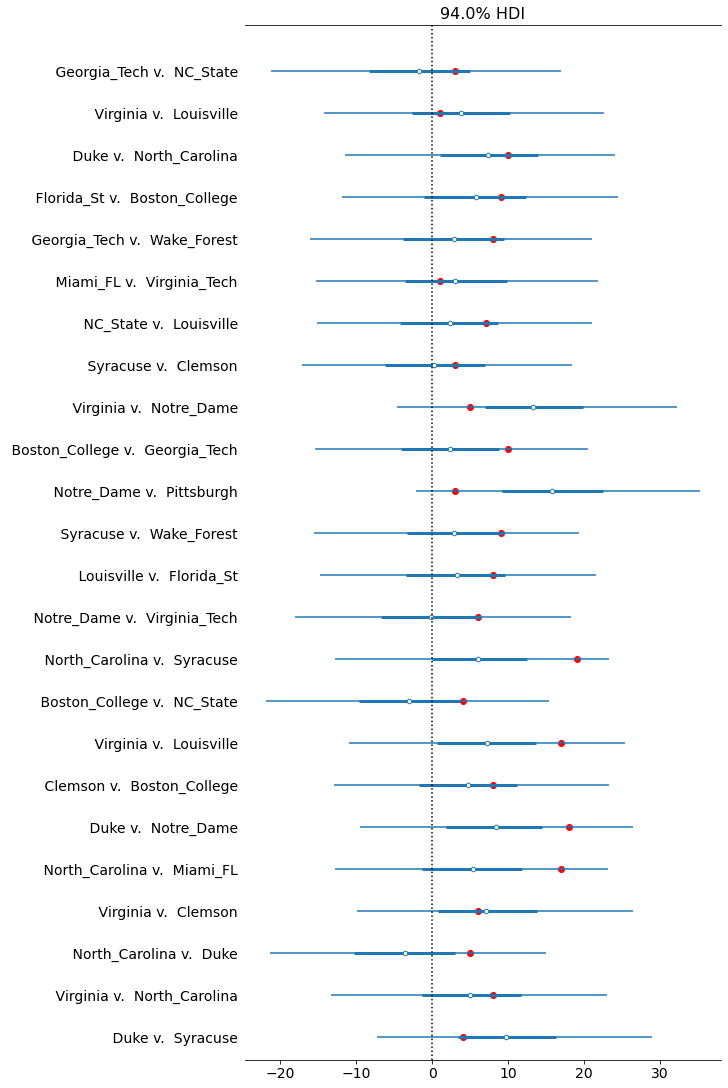

In [210]:
# diff_test = fit.extract()['diff_test']
axes = arviz.plot_forest(fit, var_names='diff_test', combined=True, figsize=(10, 15))
# axes[0].grid()
axes[0].axvline(0, c='black', ls=':')
y_vals = axes[0].get_yticks()
x_vals = np.flip((test['score_i'] - test['score_j']).values)
team_is = teams.loc[test['team_i'], 'team_name'].tolist()
team_js = teams.loc[test['team_j'], 'team_name'].tolist()
team_labels = np.flip([' v. '.join(t) for t in zip(team_is, team_js)])
axes[0].scatter(x_vals, y_vals, c='red')
axes[0].set_yticklabels(team_labels)
plt.show()

In [137]:
# Copied code from the Bayesian blog <http://doogan.us/nj/NCAA2018.html>

for var in ['i', 'j']:
    train[f'home_{var}'] = (train[f'home_{var}'] == 1).astype(int)

model_code = """
data{
    int N;
    vector[N] y;
    int team_i[N];
    int team_j[N];
    int h_i[N];
    int h_j[N];
    int N_g;
  }
  parameters{
    vector[N_g] alpha_raw;
    vector[N_g] theta_raw;
    real eta;
    real<lower=0> tau_theta;
    real<lower=0> tau_alpha;
    real<lower=0> sigma;
  }
  transformed parameters{
    vector[N_g] alpha;
    vector[N_g] theta;
    alpha = eta + alpha_raw*tau_alpha;
    theta = theta_raw*tau_theta;
  }
  model{
    // vector for conditional mean storage
    vector[N] mu;

    // priors
    tau_theta ~ cauchy(0,1)T[0,];
    tau_alpha ~ cauchy(0,.25)T[0,];
    sigma ~ cauchy(0,1)T[0,];
    eta ~ normal(4,1);
    theta_raw ~ normal(0,1);
    alpha_raw ~ normal(0,1);

    // define mu for the Gaussian
    for( t in 1:N ) {
      mu[t] = (theta[team_i[t]] + alpha[team_i[t]]*h_i[t]) - 
              (theta[team_j[t]] + alpha[team_j[t]]*h_j[t]);
    }

    // the likelihood
    y ~ normal(mu,sigma);
  }
"""

dat = {
    'N_g': len(np.union1d(train['team_i'].unique(), train['team_j'].unique())),
    'N': len(train),
    'h_i': train['home_i'],
    'h_j': train['home_j'],
    'team_i': train['team_i'],
    'team_j': train['team_j'],
    'y': train['score_i'] - train['score_j']
}

sm = pystan.StanModel(model_code=model_code)
print('fitting model')
fit = sm.sampling(data=dat, warmup=500, iter=2500, chains=2, refresh=100)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_438bc940798f71e572bd2d2621169a53 NOW.
fitting model


In [138]:
# arviz.plot_trace(fit, var_names=["theta", "eta", "tau_theta", "sigma"])
print(fit)


Inference for Stan model: anon_model_438bc940798f71e572bd2d2621169a53.
2 chains, each with iter=2500; warmup=500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%    25%     50%    75%  97.5%  n_eff   Rhat
alpha_raw[1]   0.08    0.02   0.98   -1.83  -0.58    0.06   0.72   2.05   2960    1.0
alpha_raw[2]  -0.11    0.02   0.96   -1.94  -0.74   -0.11   0.53   1.75   2940    1.0
alpha_raw[3]  -0.07    0.02   0.99   -1.96  -0.73   -0.09   0.58   1.86   3604    1.0
theta_raw[1]   1.16    0.02   0.73   -0.26   0.68    1.15   1.63   2.71   2289    1.0
theta_raw[2] 8.5e-4    0.01   0.58   -1.14  -0.38 -1.6e-3    0.4   1.11   2345    1.0
theta_raw[3]  -1.16    0.02   0.74   -2.65  -1.65   -1.14  -0.64   0.23   1850    1.0
eta             3.7  8.0e-3   0.39    2.95   3.43     3.7   3.96   4.47   2422    1.0
tau_theta     10.14    0.12   4.32    4.49    6.9    9.09  12.41  21.35   1404    1.0
tau_alpha       0.3  7.5e-3   0.36 10.

In [87]:
df = fit.to_dataframe()

In [89]:
df.head()

,chain,draw,warmup,theta[1],theta[2],theta[3],eta,sigma,tau_theta,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,3.717101,3.466873,-6.302233,3.396961,8.374652,3.046611,-2627.093747,0.931592,0.030344,6,63,0,2631.124120
1,0,1,0,8.092550,1.302020,-3.543360,2.535004,8.263849,7.859762,-2628.720879,0.831783,0.030344,7,127,0,2630.676739
2,0,2,0,5.834874,-0.693781,-0.717682,7.706067,8.103053,2.698475,-2627.938097,0.943037,0.030344,6,127,0,2631.204650
3,0,3,0,3.724824,0.905172,-4.881214,5.603894,8.539398,4.088130,-2626.727861,0.964844,0.030344,6,95,0,2630.415585
4,0,4,0,1.255632,-2.159115,-7.577390,5.373523,8.559258,3.348577,-2627.698618,0.997746,0.030344,4,31,0,2629.185769


## Create Fake data to test system


In [128]:
num_teams = 3
thetas = np.array([10, 0, -10])
sigma = 7.5
start_date = pd.to_datetime("2018-11-15")
season_days = 100
num_games = 1000

all_rows = []
for i in range(num_games):
    row_dict = {}
    curr_teams = np.random.choice(np.arange(num_teams), 2, replace=False)
    scores = np.round(np.random.normal(thetas[curr_teams] + 70, sigma))
    scores[0] += 3
    win_ind = curr_teams[scores.argmax()]
    lose_ind = curr_teams[scores.argmin()]
    row_dict['team_i'] = win_ind + 1
    row_dict['team_j'] = lose_ind + 1
    row_dict['game_id'] = i
    row_dict['score_i'] = scores.max()
    row_dict['score_j'] = scores.min()
    if row_dict['team_i'] - 1 == curr_teams[0]:
        row_dict['home_i'] = 1
        row_dict['home_j'] = -1
    else:
        row_dict['home_i'] = -1
        row_dict['home_j'] = 1
    row_dict['date'] = start_date + pd.to_timedelta(np.random.choice(season_days), "days")
    all_rows.append(row_dict)

fake_df = pd.DataFrame(all_rows)



In [129]:
fake_df.to_csv(here('data/fake_data.csv'), index=False)